In [1]:
import keras
import matplotlib.pyplot as plt
import numpy as np
from keras import backend as K
from keras.layers import Conv1D, Conv2D, Dense, Input, Concatenate, Reshape, Lambda
from keras.models import load_model
from keras.utils import plot_model
from scipy import stats as ss
from scipy import optimize
from scipy.interpolate import griddata
from IPython.display import Image, display

import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook as tqdm
from itertools import product

Using TensorFlow backend.


In [2]:
def create_model(grid_size, n_dense_layers, dense_1_scaling, depth, kernel_size, n_kernels):
    out_dense_2 = (grid_size + kernel_size - 1) // n_dense_layers
    n_samples_new = out_dense_2 * n_dense_layers - kernel_size + 1
    
    if n_samples_new != grid_size:
        print("grid_size adjusted from", grid_size, "to", n_samples_new)
        grid_size = n_samples_new
    else:
        print("parameters match for grid size", grid_size)

    model = Input(shape=(2,), name='input')
    print("Shape after input:", model.shape)

    layer_1 = []
    layer_2 = []
    reshape = []
    
    for i in range(n_dense_layers):
        layer_1.append(Dense(dense_1_scaling * depth, activation='relu', name='dense_level_1_{:02d}'.format(i))(model))
        layer_2.append(Dense(out_dense_2 * depth, activation='relu', name='dense_level_2_{:02d}'.format(i))(layer_1[-1]))
        reshape.append(Reshape(target_shape=(out_dense_2, depth, 1))(layer_2[-1]))
    
    concat = Concatenate(axis=-1)(reshape)
    print("Shape after concat:", concat.shape)
    
    reshape = Reshape(target_shape=(grid_size + kernel_size - 1, depth, 1))(concat)
    print("Shape after reshape:", reshape.shape)
    
    conv = Conv2D(filters=n_kernels, kernel_size=(kernel_size, depth), strides=1)(reshape)
    
    avg = Lambda(lambda x: K.sum(x, axis=-1), output_shape=lambda s: (s[0], s[1]))(conv)
    print("Shape after avg:", avg.shape)
    
    reshape_after_avg = Reshape(target_shape=(grid_size,))(avg)
    print("Shape after reshape:", reshape.shape)    
    
    model = keras.Model(model, reshape_after_avg)
    
    plot_model(model, show_shapes=True, to_file='model.png')
    display(Image(retina=True, filename='model.png'))
    
    return model, grid_size

In [3]:
def gen_data(n_sampled_params, grid_size):
    mu = ss.uniform(MIN_MU, MAX_MU - MIN_MU).rvs(n_sampled_params) # TODO Once we use classes, make these attributes.
    sd = ss.uniform(MIN_SD, MAX_SD - MIN_SD).rvs(n_sampled_params)
    x = np.linspace(MIN_X, MAX_X, grid_size)
    # TODO Make sure that distributions don't get off the grid (truncated).

    params = np.concatenate((mu[..., np.newaxis], sd[..., np.newaxis]), 1)
    x_grid = ss.norm(mu[:, np.newaxis], sd[:, np.newaxis]).logpdf(x[np.newaxis, :])
    
    return params, x_grid

In [6]:
# Define parameter range.
MIN_X, MAX_X = -10, 10
MIN_MU, MAX_MU = -3, 3
MIN_SD, MAX_SD = 0.5, 3

# Data settings.
N_DATA_IN = 50000
grid_size = 100 # May be dynamic, depending on model parameters.

# NN Settings.
N_DENSE_LAYERS = 20
DENSE_1_SCALING = 1
DEPTH = 25
KERNEL_SIZE = 40 # TODO Consider adding this as a fraction of the grid size.
N_KERNELS = 15

# Fitting Settings.
N_EPOCHS = 3

In [11]:
from keras.callbacks import Callback

class LossHistory(Callback):
    """
    TBA
    """

    def on_train_begin(self, logs={}):
        self.losses = []

    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))

parameters match for grid size 81
Shape after input: (?, 2)
Shape after concat: (?, 6, 25, 20)
Shape after reshape: (?, 120, 25, 1)
Shape after avg: (?, 81, 1)
Shape after reshape: (?, 120, 25, 1)


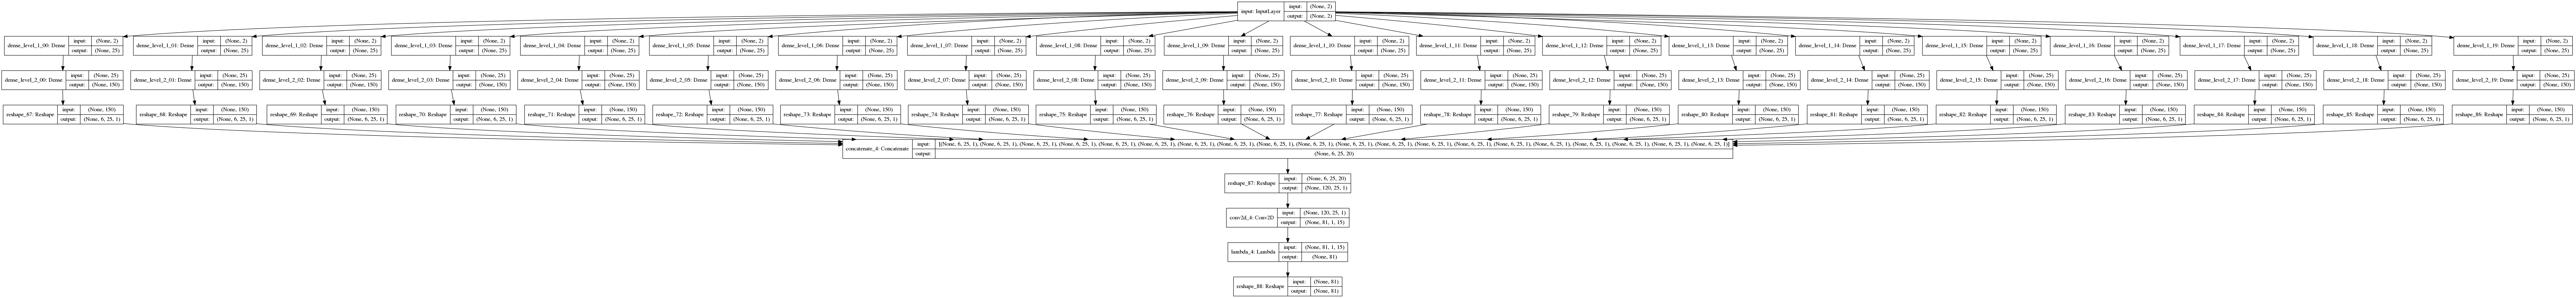

Epoch 1/3
50000/50000 [==============================] - 10s 205us/step - loss: 86.0730
Epoch 2/3
50000/50000 [==============================] - 10s 191us/step - loss: 0.6288
Epoch 3/3
50000/50000 [==============================] - 9s 175us/step - loss: 0.1788


In [12]:
model, grid_size = create_model(grid_size, N_DENSE_LAYERS, DENSE_1_SCALING, DEPTH, KERNEL_SIZE, N_KERNELS)
model.compile(optimizer='adam', loss='mean_squared_error')
params, x_grid = gen_data(N_DATA_IN, grid_size)
history = LossHistory()
history = model.fit(params, x_grid, shuffle=True, batch_size=64, epochs=N_EPOCHS, callbacks=[history])

In [14]:
history.

In [24]:
d1 = pd.DataFrame(history.history['loss'], columns=['a'])

In [25]:
d2 = d1[:-1]

In [26]:
d2

,a
0,86.073011
1,0.628795


In [22]:
pd.concat([d1, d2], axis=1)

,0,0
0,86.073011,86.073011
1,0.628795,0.628795
2,0.178818,NaN


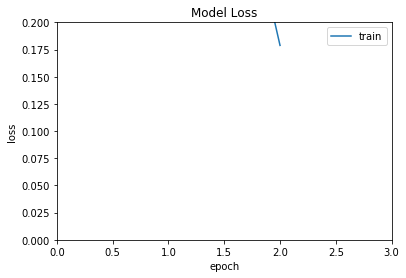

In [15]:
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.xlim(0, N_EPOCHS)
plt.ylim((0, 0.2))
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [19]:
# Only use this when we actually trained a good model...
model.save('model.h5')

In [8]:
predictions = model.predict(params)

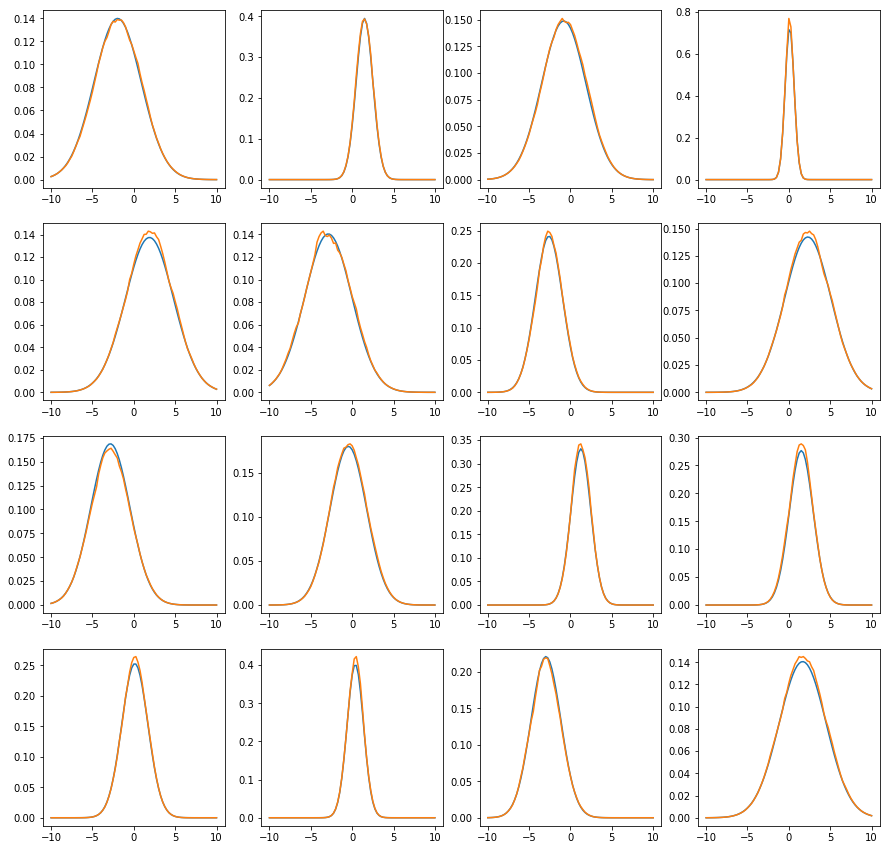

In [9]:
plt.figure(figsize=(15, 15))

for i, ix in enumerate(np.linspace(0, len(predictions), 16, dtype=int, endpoint=False)):
    plt.subplot(4, 4, i + 1)
    
    plt.plot(np.linspace(MIN_X, MAX_X, grid_size), np.exp(x_grid[ix, :]))
    plt.plot(np.linspace(MIN_X, MAX_X, grid_size), np.exp(predictions[ix, :]))

In [28]:
def log_likelihood(model, theta, x_grid, x):
    if np.abs(theta[0]) > 3 or theta[1] < 0.5 or theta[1] > 3: # TODO Adjust this accordingly.
        return -1e9
    
    theta = np.atleast_2d(theta)
    likelihood_on_grid = model.predict(theta).T
    
    points = np.atleast_2d(x_grid).T

    ll = griddata(x_grid, likelihood_on_grid, x, fill_value=-1e9)
    
    return ll

In [3]:
def get_summed_ll(model, theta, x_grid, x):
    return np.sum(log_likelihood(model, theta, x_grid, x))

In [4]:
def estimate_mu(model, x_grid, x):
    return optimize.minimize(lambda theta: -get_summed_ll(model, theta, x_grid, x), 
                             x0=[0, 1], 
                             method='Nelder-Mead').x[0:2]

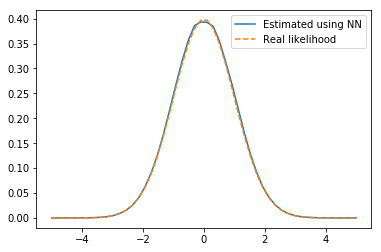

In [13]:
theta = np.array([0, 1]) # Mean 0, SD 1.
test_grid = np.linspace(MIN_X, MAX_X, grid_size)
samples = np.linspace(-5, 5)
ll = log_likelihood(model, theta, test_grid, samples)
    
plt.plot(samples, np.exp(ll), label='Estimated using NN')
plt.plot(samples, ss.norm().pdf(samples), ls='--', label='Real likelihood')
plt.legend()

In [14]:
test_grid = np.linspace(MIN_X, MAX_X, grid_size)
x = ss.norm(0.8, 0.6).rvs(50)
est = estimate_mu(model, test_grid, x)
print('Mu:', est[0], 'Sigma:', est[1])

Mu: 0.9075522548970592 Sigma: 0.5684262971519909


In [15]:
df = []
df1 = []

n_ns = 10
n_runs = 10
n_params = 5

mus = ss.uniform(MIN_MU, MAX_MU - MIN_MU).rvs(n_params)
sigmas = ss.uniform(MIN_SD, MAX_SD - MIN_SD).rvs(n_params)

pars = product(np.linspace(50, 100, n_ns, dtype=int), np.arange(n_runs), zip(mus, sigmas))
test_grid = np.linspace(MIN_X, MAX_X, grid_size)

with tqdm(total=n_ns*n_params*n_runs) as t:
    for n, trial, params in pars:
        test_data = ss.norm(params[0], params[1]).rvs(n)

        params_est = estimate_mu(model, test_grid, test_data)
        mu_estimate = params_est[0]
        sigma_estimate = params_est[1]
        
        ml_mu_estimate = np.mean(test_data)
        ml_sigma_estimate = np.std(test_data)

        df.append({'n':n,
                   'trial':trial,
                   'mu':params[0],
                   'mu_nn':mu_estimate,
                   'mu_ml':ml_mu_estimate})
        
        df1.append({'n':n,
                    'trial':trial,
                    'sigma':params[1],
                    'sigma_nn':sigma_estimate,
                    'sigma_ml':ml_sigma_estimate})
        t.update()
    
df = pd.DataFrame(df)
df1 = pd.DataFrame(df1)

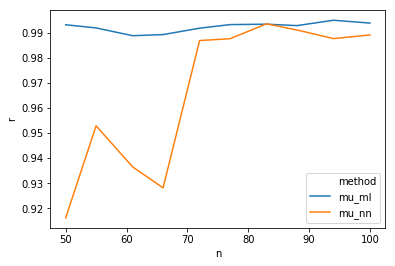

In [16]:
df_ = df.melt(id_vars=['mu', 'n', 'trial'], var_name='method', value_name='estimate')
tmp = df_.groupby(['n', 'method']).apply(lambda d: ss.pearsonr(d['estimate'], d['mu'])[0]).to_frame('r')
sns.lineplot('n', 'r', 'method', data=tmp.reset_index())

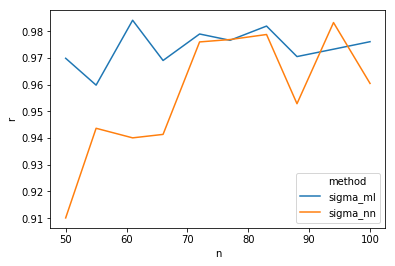

In [17]:
df1_ = df1.melt(id_vars=['sigma', 'n', 'trial'], var_name='method', value_name='estimate')
tmp1 = df1_.groupby(['n', 'method']).apply(lambda d: ss.pearsonr(d['estimate'], d['sigma'])[0]).to_frame('r')
sns.lineplot('n', 'r', 'method', data=tmp1.reset_index())

In [6]:
from keras import backend as K

m = load_model('/home/simon/Desktop/output/gs500-20190528235518/model.h5', custom_objects={"backend": K})

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


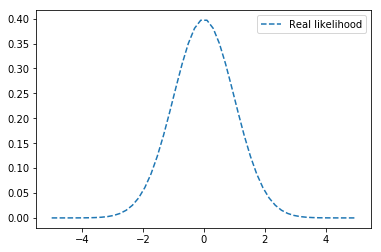

In [32]:
theta = np.array([0, 1]) # Mean 0, SD 1.
test_grid = np.linspace(-10, 10, 481)
samples = np.linspace(-5, 5)
ll = log_likelihood(m, theta, test_grid, samples)
    
#plt.plot(samples, np.exp(ll), label='Estimated using NN')
plt.plot(samples, ss.norm(theta[0], theta[1]).pdf(samples), ls='--', label='Real likelihood')
plt.legend()